In [1]:
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()
chat_model=ChatGroq(model="llama3-8b-8192")

In [2]:
from typing import TypedDict, List, Any
from langchain_community.vectorstores import Chroma

class PDFChatState(TypedDict):
    pdfpath: str
    pdf: List[Any]   # list of Documents
    userQuery: str
    userQueryCategory: Any  # placeholder for your custom class
    extracted_text: str
    splitted_text: List[Any]  # list of text chunks/documents
    vectordb: Chroma
    similar_pages: List[Any]  # retrieved docs
    similar_pages_content: str
    answer:str


In [3]:
from pydantic import BaseModel, Field
from enum import Enum

class QueryCategoryEnum(str, Enum):
    qa = "qa"               # Answer a question using retrieved pages from the PDF
    summpdf = "summpdf"     # Summarize the entire PDF content
    quizpdf = "quizpdf"     # Generate a 10-question quiz for the entire PDF
    summtopic = "summtopic" # Summarize a specific topic from the PDF using relevant pages
    quiztopic = "quiztopic" # Generate a 10-question quiz on a specific topic from the PDF

class UserQueryCategory(BaseModel):
    category: QueryCategoryEnum = Field(
        ...,
        description=(
            "Category of the user query. Must be one of:\n"
            "- qa → Answer a question using retrieved pages from the PDF\n"
            "- summpdf → Summarize the entire PDF\n"
            "- quizpdf → Generate a 10-question quiz for the entire PDF\n"
            "- summtopic → Summarize a specific topic from the PDF\n"
            "- quiztopic → Generate a 10-question quiz on a specific topic from the PDF"
        )
    )


In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

# Parser
parser = PydanticOutputParser(pydantic_object=UserQueryCategory)

# Prompt template
classification_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a query classifier. Your job is to classify user queries "
               "into one of the following categories: qa, summpdf, quizpdf, summtopic, quiztopic."),
    ("human", "Query: {query}\n\n{format_instructions}")
]).partial(format_instructions=parser.get_format_instructions())

# Classification chain
classification_chain = classification_prompt | chat_model | parser


In [5]:
from langchain_community.document_loaders import PyPDFLoader
import os

# --- Node Function ---
def load_pdf_node(state: PDFChatState) -> PDFChatState:
    """
    Node: Loads PDF and classifies user query.
    Inputs: pdfpath, userQuery
    Updates: pdfpath, pdf, userQuery, userQueryCategory
    """

    pdfpath = state.get("pdfpath")
    userQuery = state.get("userQuery")

    # 1. Load PDF
    if not os.path.exists(pdfpath):
        raise FileNotFoundError(f"PDF file '{pdfpath}' not found.")

    loader = PyPDFLoader(pdfpath)
    pdf = loader.load()

    # 2. Classify userQuery into category using classification_chain
    userQueryCategory = classification_chain.invoke({"query": userQuery})

    # 3. Update state
    state.update({
        "pdfpath": pdfpath,
        "pdf": pdf,
        "userQuery": userQuery,
        "userQueryCategory": userQueryCategory
    })

    return state


In [6]:
def extract_text_node(state: PDFChatState) -> PDFChatState:
    """
    Node: Extract full text from loaded PDF.
    Input: pdf
    Updates: extracted_text
    """

    pdf = state.get("pdf", [])

    if not pdf:
        raise ValueError("No PDF content found in state. Did you run load_pdf_node first?")

    # Extract text
    full_text = "\n".join([doc.page_content for doc in pdf])

    # Update state
    state.update({
        "extracted_text": full_text
    })

    return state


In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_pdf_node(state: PDFChatState) -> PDFChatState:
    """
    Node: Split PDF into smaller chunks.
    Input: pdf
    Updates: splitted_text
    """

    pdf = state.get("pdf", [])

    if not pdf:
        raise ValueError("No PDF content found in state. Did you run load_pdf_node first?")

    # Split PDF
    splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=20)
    splitted_text = splitter.split_documents(pdf)

    # Update state
    state.update({
        "splitted_text": splitted_text
    })

    return state


In [8]:
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
import os

# Embedding setup
os.environ['HF_HOME'] = 'C:/Users/Aditya/Desktop/Langchain/Langchain_Models/LOCALINSTALLEDMODELS'
embedding_model = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

PERSIST_DIR = "./chroma_persist"
CHROMA_COLLECTION_NAME = "pdf_docs"

def embed_pdf_node(state: PDFChatState) -> PDFChatState:
    """
    Node: Embed PDF chunks into ChromaDB.
    Input: splitted_text
    Updates: vectordb
    """

    splitted_text = state.get("splitted_text", [])

    if not splitted_text:
        raise ValueError("No splitted_text found in state. Did you run split_pdf_node first?")

    # Check if persistence exists
    if os.path.exists(PERSIST_DIR) and os.listdir(PERSIST_DIR):
        vectordb = Chroma(
            persist_directory=PERSIST_DIR,
            embedding_function=embedding_model,
            collection_name=CHROMA_COLLECTION_NAME
        )
    else:
        vectordb = Chroma.from_documents(
            splitted_text,
            embedding_model,
            persist_directory=PERSIST_DIR,
            collection_name=CHROMA_COLLECTION_NAME
        )
        vectordb.persist()

    # Update state
    state.update({
        "vectordb": vectordb
    })

    return state


c:\Users\Aditya\Desktop\StudyCompanionAgents\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def get_similar_pages_node(state: PDFChatState) -> PDFChatState:
    """
    Node: Retrieve similar pages from vectordb based on userQuery.
    Inputs: userQuery, vectordb
    Updates: similar_pages, similar_pages_content
    """

    userQuery = state.get("userQuery", "")
    vectordb = state.get("vectordb", None)

    if not userQuery:
        raise ValueError("No userQuery found in state.")
    if vectordb is None:
        raise ValueError("No vectordb found in state. Did you run embed_pdf_node first?")

    # Retrieve documents
    vectordb_retriever = vectordb.as_retriever(search_type="mmr", search_kwargs={"k": 5})
    similar_pages = vectordb_retriever.get_relevant_documents(userQuery)

    # Combine page content for easy LLM consumption
    similar_pages_content = "\n\n".join([doc.page_content for doc in similar_pages])

    # Update state
    state.update({
        "similar_pages": similar_pages,
        "similar_pages_content": similar_pages_content
    })

    return state


In [10]:
def answer_question_on_query_node(state: PDFChatState) -> PDFChatState:
    """
    Node: Answer a question based on retrieved similar pages.
    Inputs: similar_pages_content, userQuery
    Updates: answer
    """

    similar_pages_content = state.get("similar_pages_content", "")
    user_query = state.get("userQuery", "")

    if not user_query:
        raise ValueError("No userQuery found in state.")
    if not similar_pages_content:
        raise ValueError("No similar_pages_content found in state. Did you run get_similar_pages_node first?")

    # Create prompt
    prompt = (
        f"Answer the question using the following context:\n\n"
        f"{similar_pages_content}\n\n"
        f"Question: {user_query}\n\n"
        f"Also add your suggestions in the answer if there is lack of context."
    )

    # Call LLM
    answer = chat_model.invoke(prompt).content

    # Update state
    state.update({
        "answer": answer
    })

    return state


In [11]:
def summarize_on_topic_node(state: PDFChatState) -> PDFChatState:
    """
    Node: Summarize a specific topic using retrieved similar pages.
    Inputs: similar_pages_content, userQuery (used as topic)
    Updates: answer
    """

    similar_pages_content = state.get("similar_pages_content", "")
    topic = state.get("userQuery", "")

    if not topic:
        raise ValueError("No topic (userQuery) found in state.")
    if not similar_pages_content:
        raise ValueError("No similar_pages_content found in state. Did you run get_similar_pages_node first?")

    # Build prompt
    prompt = (
        f"Summarize the following content in detail:\n\n"
        f"Topic: {topic}\n\n"
        f"Context:\n{similar_pages_content}\n\n"
        f"Also add your suggestions in the summary if there is lack of context."
    )

    # Call LLM
    summary = chat_model.invoke(prompt).content

    # Update state
    state.update({
        "answer": summary
    })

    return state


In [12]:
def generate_quiz_on_topic_node(state: PDFChatState) -> PDFChatState:
    """
    Node: Generate a 10-question quiz on a specific topic using retrieved similar pages.
    Inputs: similar_pages_content, userQuery
    Updates: answer
    """

    similar_pages_content = state.get("similar_pages_content", "")
    user_query = state.get("userQuery", "")

    if not user_query:
        raise ValueError("No userQuery found in state.")
    if not similar_pages_content:
        raise ValueError("No similar_pages_content found in state. Did you run get_similar_pages_node first?")

    # Build prompt
    prompt = (
        f"Based on the following content:\n{similar_pages_content}\n\n"
        f"Create a quiz of 10 questions with answers at the end "
        f"on the topic: {user_query}.\n\n"
        f"Also add your suggestions in the quiz if there is lack of context."
    )

    # Call LLM
    quiz = chat_model.invoke(prompt).content

    # Update state
    state.update({
        "answer": quiz
    })

    return state


In [13]:
def summarize_text_node(state: PDFChatState) -> PDFChatState:
    """
    Node: Summarize the entire PDF text.
    Input: extracted_text
    Updates: answer
    """

    extracted_text = state.get("extracted_text", "")

    if not extracted_text:
        raise ValueError("No extracted_text found in state. Did you run extract_text_node first?")

    # Build prompt
    prompt = f"Summarize the following content in detail:\n\n{extracted_text}"

    # Call LLM
    summary = chat_model.invoke(prompt).content

    # Update state
    state.update({
        "answer": summary
    })

    return state


In [14]:
def generate_quiz_node(state: PDFChatState) -> PDFChatState:
    """
    Node: Generate a 10-question quiz for the entire PDF.
    Input: extracted_text
    Updates: answer
    """

    extracted_text = state.get("extracted_text", "")

    if not extracted_text:
        raise ValueError("No extracted_text found in state. Did you run extract_text_node first?")

    # Build prompt
    prompt = (
        "Based on the following content, create a quiz of 10 questions "
        "with answers at the end:\n\n"
        f"{extracted_text}"
    )

    # Call LLM
    quiz = chat_model.invoke(prompt).content

    # Update state
    state.update({
        "answer": quiz
    })

    return state


In [15]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(PDFChatState)

# --- Add Nodes ---
workflow.add_node("load_pdf", load_pdf_node)
workflow.add_node("extract_text", extract_text_node)
workflow.add_node("split_pdf", split_pdf_node)
workflow.add_node("embed_pdf", embed_pdf_node)
workflow.add_node("get_similar_pages", get_similar_pages_node)

workflow.add_node("answer_question_on_query", answer_question_on_query_node)
workflow.add_node("summarize_on_topic", summarize_on_topic_node)
workflow.add_node("generate_quiz_on_topic", generate_quiz_on_topic_node)
workflow.add_node("summarize_text", summarize_text_node)
workflow.add_node("generate_quiz", generate_quiz_node)

# --- Router functions ---
def first_router(state: PDFChatState):
    """Route based on whether query is PDF-level or retrieval-level."""
    category = state["userQueryCategory"].category
    if category in ["summpdf", "quizpdf"]:
        return "extract_text"
    else:
        return "split_pdf"

def second_router(state: PDFChatState):
    """Route retrieval-based queries to the correct node."""
    category = state["userQueryCategory"].category
    if category == "qa":
        return "answer_question_on_query"
    elif category == "summtopic":
        return "summarize_on_topic"
    elif category == "quiztopic":
        return "generate_quiz_on_topic"
    else:
        raise ValueError(f"Invalid category for retrieval path: {category}")

def pdf_router(state: PDFChatState):
    """Route PDF-level queries to the correct node."""
    category = state["userQueryCategory"].category
    if category == "summpdf":
        return "summarize_text"
    elif category == "quizpdf":
        return "generate_quiz"
    else:
        raise ValueError(f"Invalid category for PDF path: {category}")

# --- Edges ---
workflow.set_entry_point("load_pdf")

# First branching
workflow.add_conditional_edges(
    "load_pdf",
    first_router,
    {
        "extract_text": "extract_text",
        "split_pdf": "split_pdf"
    }
)

# PDF path
workflow.add_conditional_edges(
    "extract_text",
    pdf_router,
    {
        "summarize_text": "summarize_text",
        "generate_quiz": "generate_quiz"
    }
)
workflow.add_edge("summarize_text", END)
workflow.add_edge("generate_quiz", END)

# Retrieval path
workflow.add_edge("split_pdf", "embed_pdf")
workflow.add_edge("embed_pdf", "get_similar_pages")

workflow.add_conditional_edges(
    "get_similar_pages",
    second_router,
    {
        "answer_question_on_query": "answer_question_on_query",
        "summarize_on_topic": "summarize_on_topic",
        "generate_quiz_on_topic": "generate_quiz_on_topic"
    }
)

workflow.add_edge("answer_question_on_query", END)
workflow.add_edge("summarize_on_topic", END)
workflow.add_edge("generate_quiz_on_topic", END)

# --- Compile graph ---
app = workflow.compile()


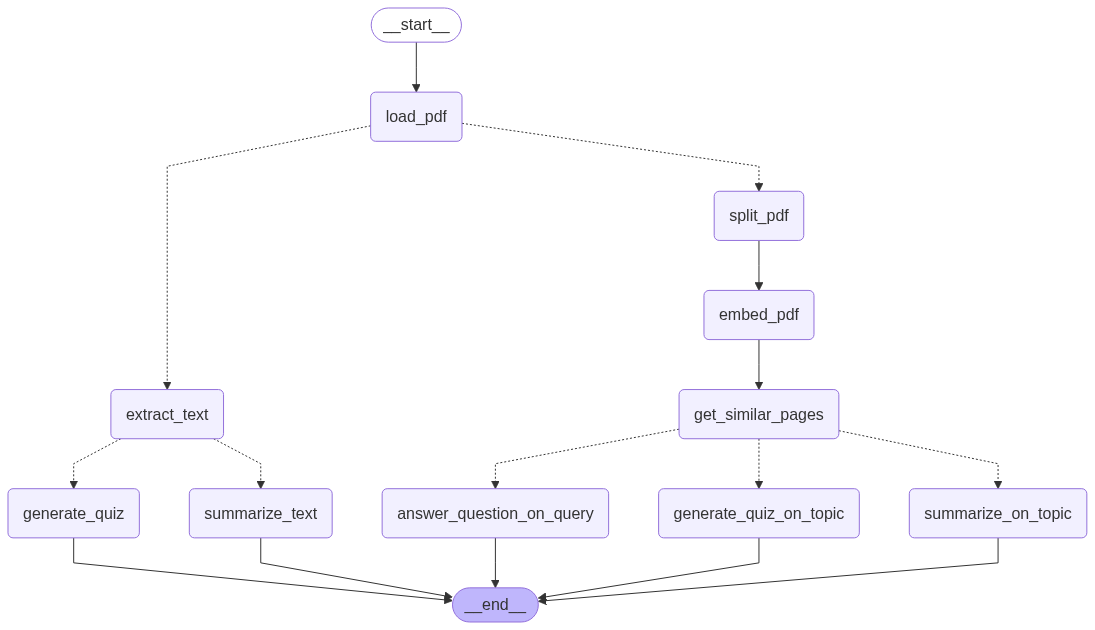

In [16]:
app

In [19]:
initial_state = PDFChatState(
    pdfpath="container.pdf",   # your Spring Boot PDF file
    userQuery="What is Java Bean in Spring Boot?",  # your question
)


In [18]:
final_state = app.invoke(initial_state)
print("Answer:", final_state["answer"])


C:\Users\Aditya\AppData\Local\Temp\ipykernel_24156\1607671186.py:26: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(
C:\Users\Aditya\AppData\Local\Temp\ipykernel_24156\2485103155.py:18: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  similar_pages = vectordb_retriever.get_relevant_documents(userQuery)


Answer: Based on the provided context, a Spring Bean is a Java object that is managed by the Spring IoC (Inversion of Control) container. In other words, a Spring Bean is a Java class that is instantiated, configured, and managed by the Spring Framework.

In the context of Spring Boot, a Spring Bean is a Java class that is annotated with the `@Bean` annotation, indicating that the class produces a bean that can be used by the Spring container. This bean can be a service, a repository, a controller, or any other type of object that needs to be managed by the Spring container.

For example:
```java
@Bean
public ServletContext servletContext() {
    return new ServletContext();
}
```
In this example, the `servletContext()` method returns a `ServletContext` object, which is a Spring Bean that can be used by the Spring container.

In the context of Spring Boot, the goals of using Spring Beans include:

1. Inversion of Control (IoC): Spring Beans allow for loose coupling between objects, mak

In [20]:
initial_state = PDFChatState(
    pdfpath="container.pdf",   # your Spring Boot PDF file
    userQuery="give quiz on dependancy injection",  # your question
)


In [21]:
final_state = app.invoke(initial_state)
print("Answer:", final_state["answer"])


Answer: Here's a quiz on Dependency Injection with 10 questions:

**Quiz: Dependency Injection**

**1. What is Dependency Injection?**
a) A way to manually set dependencies in an object
b) A way to automatically set dependencies in an object
c) A way to remove dependencies from an object
d) A way to add dependencies to an object

Answer: b) A way to automatically set dependencies in an object

**2. What is IOC (Inversion of Control) in Dependency Injection?**
a) The process of manually setting dependencies in an object
b) The process of automatically setting dependencies in an object
c) The concept of reversing the control of dependencies
d) The concept of introducing dependencies in an object

Answer: c) The concept of reversing the control of dependencies

**3. What is Auto Wiring in Dependency Injection?**
a) A way to manually set dependencies in an object
b) A way to automatically set dependencies in an object
c) A way to remove dependencies from an object
d) A way to add dependenc

In [22]:
initial_state = PDFChatState(
    pdfpath="container.pdf",   # your Spring Boot PDF file
    userQuery="give short and crisp explanation for dependancy injection",  # your question
)


In [23]:
final_state = app.invoke(initial_state)
print("Answer:", final_state["answer"])


Answer: Here's a short and crisp explanation for Dependency Injection:

**Dependency Injection (DI)**: A software design pattern that allows components to be loosely coupled by providing their dependencies, rather than creating them internally. In other words, instead of an object creating its own dependencies, they are injected into the object from outside, making it easier to test, maintain, and extend the application.

**Example**: Consider a simple calculator that needs an addition and subtraction service to perform calculations. With Dependency Injection, instead of the calculator creating its own addition and subtraction services, it would receive them as dependencies from outside. This decouples the calculator from the specific implementation of the services, making it easier to switch or replace them if needed.

**Benefits**:

* Looser coupling between components
* Easier testing and maintenance
* Greater flexibility and extensibility
* Improved scalability and reuse

**Suggest